In [17]:
import numpy as np
import pandas as pd

Definimos las variables

In [18]:
N = 25*12 # Número de meses
r = np.zeros([N+1, N+1]) # Arbol Binomial
Q = np.zeros([N+1, N+1]) # Precios Arrow-Debreu
theta = np.zeros(N+1) # Drift
dt = 1/12 # Delta t
#sigma = 0.001006449405907745 # Volatilidad De solo el 2025
sigma  = 0.0016835430755297832

Llenar estado inicial

In [19]:
r[0][0] = 0.04761 # Tasa inicial
Q[0][0] = 1 # Precio inicial

# Leer factores de descuento
with open('df.txt', 'r') as archivo:
    discount_factors = archivo.read()
    discount_factors = discount_factors.split(',')
    for i in range(len(discount_factors)):
        discount_factors[i] = float(discount_factors[i])
    P = np.array(discount_factors)

theta[0] = (1/dt ** 2) * (np.log((np.exp(-r[0][0] * dt) + np.exp(-(r[0][0] + 2 * sigma * np.sqrt(dt)) * dt)) / (2 * P[1]))) + sigma/np.sqrt(dt)

In [20]:
r

array([[0.04761, 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       ...,
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , ..., 0.     , 0.     , 0.     ]])

Tasas nivel 1

In [21]:
r[1][1] = r[0][0] + theta[0]*dt + sigma*np.sqrt(dt)
r[0][1] = r[0][0] + theta[0]*dt - sigma*np.sqrt(dt)

Iteración de cada nivel

In [22]:
for j in range(1,N):

    # Precios Arrow-Debreu
    for i in range(0, j+1):
        if i == 0:
            Q[i][j] = np.exp(-r[i][j] * dt) * 0.5 * Q[i][j-1]
        elif i == j:
            Q[i][j] = np.exp(-r[i][j] * dt) * 0.5 * Q[j-1][j-1]
        else:
            Q[i][j] = np.exp(-r[i][j] * dt) * 0.5 * (Q[i-1][j-1] + Q[i][j-1])
    
    # f auxiliar
    f = Q[0][j]*np.exp(-r[0][j] * dt) + sum([(Q[k-1][j] + Q[k][j])*np.exp(-r[k][j] * dt) for k in range(1, j+1)]) + Q[j][j]*np.exp(-(r[0][0] + 2 * sigma * np.sqrt(dt)) * dt)
    # theta
    theta[j] = (1/dt ** 2) * np.log(f / (2 * P[j+1])) + sigma/np.sqrt(dt)

    # Tasas
    for i in range(0, j+1):
        r[i][j+1] = r[i][j] + theta[j]*dt - sigma*np.sqrt(dt)
    r[j+1][j+1] = r[j][j] + theta[j]*dt + sigma*np.sqrt(dt)

In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
def pascal_factors_funct(m: int) -> np.array:
    pascal_factors = np.zeros([m,m])
    for j in range(m):
        for i in range(m):
            if i == 0 or i==j:
                pascal_factors[i][j] = 1
            else:
                pascal_factors[i][j] = pascal_factors[i][j-1] + pascal_factors[i-1][j-1]
    return pascal_factors

def esperanza(m: int, r: np.array, pascal_factors: np.array) -> np.array:
    expected_value = np.zeros(m+1)
    for t in range(m+1):
        expected_value[t] = 2 ** (-t)*np.dot(r[:,t], pascal_factors[:,t])
    return expected_value
def plot_ho_lee_lattice(r: np.ndarray, dt: float, title="Lattice de Ho–Lee"):
    """
    r: matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
       r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt: tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt

    fig, ax = plt.subplots(figsize=(10, 5))

    # Dibujar aristas (padre j -> hijos en j+1)
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]],
                        [r[i, j], r[i, j+1]],
                        color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]],
                        [r[i, j], r[i+1, j+1]],
                        color="red", lw=0.8)

    # (Opcional) marcar nodos
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # Formato ejes
    ax.set_xlim(T[0], T[-1])
    ymin = np.nanmin(r); ymax = np.nanmax(r)
    ylim = max(abs(ymin), abs(ymax))
    pad = 0.05 * (ymax - ymin if np.isfinite(ymax - ymin) and ymax != ymin else 0.02)
    ax.set_ylim(-ylim - pad, ylim + pad)
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # muestra % (r en decimal)
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (meses)")
    ax.set_ylabel("Tasa")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

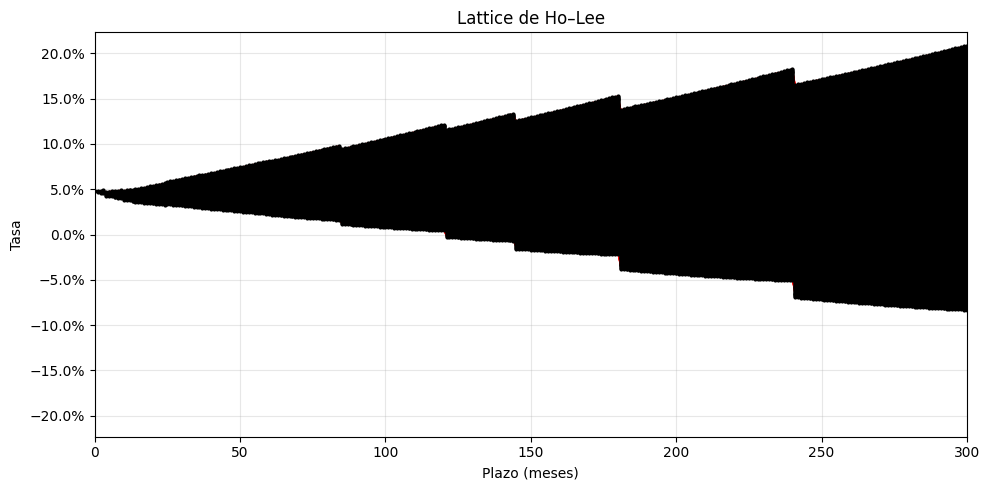

In [24]:
plot_ho_lee_lattice(r, 1)

In [25]:
theta

array([-1.24977495e-03, -3.48326234e-03, -6.70918351e-04, -2.62088841e-02,
        1.12878814e-03,  3.30015903e-03, -1.13870823e-02,  1.84567576e-03,
        2.05711952e-03, -1.43808431e-02,  1.89266776e-03,  1.93011830e-03,
       -1.16290340e-02,  1.84692529e-03,  1.86268456e-03,  1.87487806e-03,
        1.88870817e-03,  1.90264208e-03,  3.44608153e-03,  1.94219682e-03,
        1.95670987e-03,  1.97139230e-03,  1.98623629e-03,  2.00124591e-03,
        1.27358551e-02,  2.11328902e-03,  2.12973963e-03,  2.14637904e-03,
        2.16320910e-03,  2.18023302e-03,  2.19745379e-03,  2.21487447e-03,
        2.23249820e-03,  2.25032819e-03,  2.26836771e-03,  2.28662010e-03,
       -3.55364880e-03,  2.27684864e-03,  2.29519423e-03,  2.31375758e-03,
        2.33254221e-03,  2.35155169e-03,  2.37078967e-03,  2.39025987e-03,
        2.40996610e-03,  2.42991223e-03,  2.45010221e-03,  2.47054009e-03,
        8.71550807e-05,  2.49209712e-03,  2.51305117e-03,  2.53426589e-03,
        2.55574566e-03,  

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
def pascal_factors_funct(m: int) -> np.array:
    pascal_factors = np.zeros([m,m])
    for j in range(m):
        for i in range(m):
            if i == 0 or i==j:
                pascal_factors[i][j] = 1
            else:
                pascal_factors[i][j] = pascal_factors[i][j-1] + pascal_factors[i-1][j-1]
    return pascal_factors

def esperanza(m: int, r: np.array, pascal_factors: np.array) -> np.array:
    expected_value = np.zeros(m+1)
    for t in range(m+1):
        expected_value[t] = 2 ** (-t)*np.dot(r[:,t], pascal_factors[:,t])
    return expected_value

from matplotlib.ticker import PercentFormatter

def plot_ho_lee_lattice(
    r: np.ndarray,
    dt: float,
    sigma: float,
    title: str = "Lattice de Ho–Lee",
    mostrar_esperanza: bool = False
):
    """
    r : matriz triangular (n+1 x n+1) con r[i,j] definido para i<=j (NaN fuera)
        r en DECIMAL (p.ej. 0.0184 = 1.84%)
    dt : tamaño del paso en años (ej: 1/12 si mensuales, 0.25 si trimestrales)
    sigma : volatilidad anual (decimal)
    mostrar_esperanza : si True, traza E[r_t] usando pascal_factors_funct y esperanza
                        (deben existir en el namespace)
    """
    n = r.shape[0] - 1
    T = np.arange(n + 1) * dt  # eje en años

    fig, ax = plt.subplots(figsize=(10, 5))

    # --- aristas del lattice ---
    for j in range(n):
        for i in range(j + 1):
            if np.isfinite(r[i, j]) and np.isfinite(r[i, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i, j+1]], color="red", lw=0.8)
            if np.isfinite(r[i, j]) and np.isfinite(r[i+1, j+1]):
                ax.plot([T[j], T[j+1]], [r[i, j], r[i+1, j+1]], color="red", lw=0.8)

    # --- nodos ---
    for j in range(n + 1):
        y = r[:j+1, j]
        x = np.full(j + 1, T[j])
        ax.plot(x, y, "o", ms=2, color="black")

    # --- esperanza por tenor (opcional) ---
    if mostrar_esperanza:
        m = n  # nº total de pasos (meses si dt=1/12)
        # llamamos a TUS funciones (se asume que están definidas en tu entorno)
        pascal_factors = pascal_factors_funct(m+1)
        mu = esperanza(m, r, pascal_factors)  # vector de largo m+1
        ax.plot(T, mu, lw=2.2, color="blue", label="Valor esperado en plazo t")
        ax.legend(loc="upper left")

    # formato ejes
    ax.set_xlim(T[0], T[-1])
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))  # r en %
    ax.grid(True, alpha=0.3)
    ax.set_xlabel("Plazo (años)")
    ax.set_ylabel("Tasa")

    ax.set_title(f"{title} calibrado a mercado 15 septiembre de 2025 con volatilidad σ = {round(sigma*100*100,2)}bps")
    plt.savefig("holee_ewma.png", dpi=300, bbox_inches="tight", facecolor="white")
    plt.tight_layout()
    plt.show()

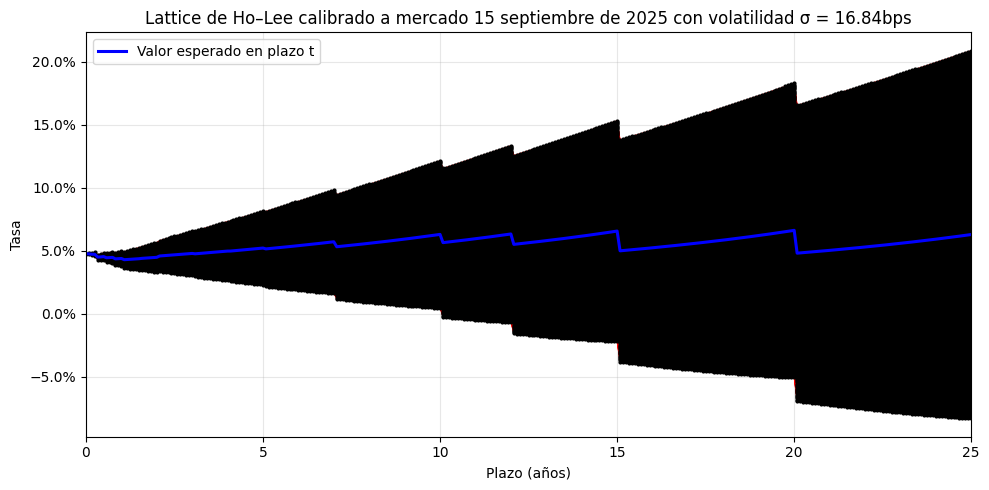

In [27]:
s = sigma
plot_ho_lee_lattice(r, dt=1/12, sigma = s, mostrar_esperanza=True)

In [28]:
theta

array([-1.24977495e-03, -3.48326234e-03, -6.70918351e-04, -2.62088841e-02,
        1.12878814e-03,  3.30015903e-03, -1.13870823e-02,  1.84567576e-03,
        2.05711952e-03, -1.43808431e-02,  1.89266776e-03,  1.93011830e-03,
       -1.16290340e-02,  1.84692529e-03,  1.86268456e-03,  1.87487806e-03,
        1.88870817e-03,  1.90264208e-03,  3.44608153e-03,  1.94219682e-03,
        1.95670987e-03,  1.97139230e-03,  1.98623629e-03,  2.00124591e-03,
        1.27358551e-02,  2.11328902e-03,  2.12973963e-03,  2.14637904e-03,
        2.16320910e-03,  2.18023302e-03,  2.19745379e-03,  2.21487447e-03,
        2.23249820e-03,  2.25032819e-03,  2.26836771e-03,  2.28662010e-03,
       -3.55364880e-03,  2.27684864e-03,  2.29519423e-03,  2.31375758e-03,
        2.33254221e-03,  2.35155169e-03,  2.37078967e-03,  2.39025987e-03,
        2.40996610e-03,  2.42991223e-03,  2.45010221e-03,  2.47054009e-03,
        8.71550807e-05,  2.49209712e-03,  2.51305117e-03,  2.53426589e-03,
        2.55574566e-03,  

In [29]:
m = N  # nº total de pasos (meses si dt=1/12)
# llamamos a TUS funciones (se asume que están definidas en tu entorno)
pascal_factors = pascal_factors_funct(m+1)
mu = esperanza(m, r, pascal_factors)  # vector de largo m+1
np.array(mu)
mu

array([0.04761   , 0.04750585, 0.04721558, 0.04715967, 0.0449756 ,
       0.04506966, 0.04534468, 0.04439575, 0.04454956, 0.04472099,
       0.04352258, 0.0436803 , 0.04384115, 0.04287206, 0.04302597,
       0.04318119, 0.04333743, 0.04349483, 0.04365338, 0.04394055,
       0.0441024 , 0.04426546, 0.04442975, 0.04459527, 0.04476204,
       0.04582336, 0.04599946, 0.04617694, 0.04635581, 0.04653608,
       0.04671776, 0.04690088, 0.04708546, 0.0472715 , 0.04745902,
       0.04764805, 0.04783861, 0.04754247, 0.04773221, 0.04792347,
       0.04811629, 0.04831066, 0.04850663, 0.04870419, 0.04890338,
       0.04910421, 0.0493067 , 0.04951088, 0.04971676, 0.04972402,
       0.0499317 , 0.05014112, 0.05035231, 0.05056528, 0.05078008,
       0.0509967 , 0.05121519, 0.05143555, 0.05165783, 0.05188203,
       0.05210819, 0.05144408, 0.05166646, 0.05189078, 0.05211705,
       0.05234531, 0.05257557, 0.05280786, 0.05304221, 0.05327866,
       0.05351721, 0.05375791, 0.05400078, 0.05424585, 0.05449

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter

# mu_exp y mu_cal: listas/arrays de largo 301 (incluye t=0)
n = len(mu)
assert len(mu_cal) == n, "Las dos series deben tener el mismo largo"

# eje x en años
x_years = np.arange(n) / 12.0  # 0, 1/12, 2/12, ..., 300/12

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_years, mu_exp, label="μ_exp", lw=2)
ax.plot(x_years, mu_cal, label="μ_cal", lw=2, linestyle="--")

ax.set_xlabel("Plazo (años)")
ax.set_ylabel("Valor")  # cambia a "Tasa" si corresponde
ax.set_xlim(0, (n-1)/12)

# Ticks: mayor cada 1 año, menor cada 0.25 años
ax.xaxis.set_major_locator(MultipleLocator(1.0))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

# Si son tasas en DECIMAL, descomenta para ver %:
# ax.yaxis.set_major_formatter(PercentFormatter(xmax=1.0, decimals=1))

ax.grid(True, which="both", alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()


NameError: name 'mu_cal' is not defined